## Formula 1
Business Problem: What factors/features are needed to predict race outcome

Things to do
- Outliers
- Natural Log

Powerpoint
- Agenda
- Background
- Business Problem: What factors/features are needed to predict race outcome
- Technical Apendix

1. Import required libraries

Get Data from the erghast F1 API
</br> Contains data from all the races since 1950

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

from statsmodels.formula.api import ols
from scipy.stats import norm, probplot
from sklearn.preprocessing import StandardScaler


db_dir = os.getcwd()
pit_stops = pd.read_csv(db_dir + r'/data/pit_stops.csv')
races = pd.read_csv(db_dir + r'/data/races.csv')
drivers = pd.read_csv(db_dir + r'/data/drivers.csv')
results = pd.read_csv(db_dir + r'/data/results.csv')
driver_standings = pd.read_csv(db_dir + r'/data/driver_standings.csv')
circuits = pd.read_csv(db_dir + r'/data/circuits.csv')
qualifying = pd.read_csv(db_dir + r'/data/qualifying.csv')

merged_df = pd.merge(races, pit_stops, on='raceId', how='inner')
df = pd.merge(merged_df, drivers, on='driverId', how='inner')
df = df.drop(columns=['url_x','url_y','number'])
df_new_merged = pd.merge(df, results, on=['driverId','raceId'], how='inner')
df_new_merged1 = pd.merge(df_new_merged, driver_standings, on=['driverId','raceId'], how='inner')
df_new_merged = pd.merge(df_new_merged, circuits, on=['circuitId'], how='inner')
condition1 = df_new_merged['year'] >= 2000
condition2 = df_new_merged['year'] <= 2023
df_new_merged1 = df_new_merged[condition1 & condition2 ] 

df_new_merged1.to_csv('all.csv')
def convert_new_time_to_seconds_v4(time_str):
    if time_str == '\\N':
        return np.nan
    try:
        # Split by colon and reverse the list to start with seconds and go backwards to minutes, hours, etc.
        time_parts = list(map(float, time_str.split(':')))[::-1]
        total_seconds = sum(time_part * (60 ** index) for index, time_part in enumerate(time_parts))
        return total_seconds
    except ValueError:
        return np.nan

# Apply the function to the 'new_time' column
df_new_merged1['new_time_seconds'] = df_new_merged1['time'].replace('\+', '', regex=True).apply(convert_new_time_to_seconds_v4)
df_cleaned = df_new_merged1[['raceId','year', 'round','circuitId','circuit_type','circuit_type_num','driverId','grid','rank','position','positionOrder','time','new_time_seconds','stop','laps','constructorId','points']]
df_cleaned = df_cleaned.drop_duplicates()
df_cleaned.sort_values(by=['raceId', 'positionOrder'], inplace=True)
df_cleaned['cumulative_time_seconds'] = df_cleaned.groupby('raceId')['new_time_seconds'].cumsum()

# Creating a variable for each of the circuit types
df_cleaned['Race_Circuit'] = np.where(df_cleaned['circuit_type_num']== 3, 1, 0)
df_cleaned['Street_Circuit'] = np.where(df_cleaned['circuit_type_num']== 2, 1, 0)
df_cleaned['Road_Circuit'] = np.where(df_cleaned['circuit_type_num']== 1, 1, 0)
df_cleaned['rank'] = df_cleaned['rank'].astype(int)

#Dropping NULL values in Cumulative race finish times - Racers not able to finish race
df_cleaned = df_cleaned.fillna(0)
print(df_new_merged1.columns)
print(df_cleaned.columns)
df_cleaned.to_csv('clean.csv')

Index(['raceId', 'year', 'round', 'circuitId', 'name_x', 'date', 'time_x',
       'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time',
       'quali_date', 'quali_time', 'sprint_date', 'sprint_time', 'driverId',
       'stop', 'lap', 'time_y', 'duration', 'milliseconds_x', 'driverRef',
       'code', 'forename', 'surname', 'dob', 'nationality', 'resultId',
       'constructorId', 'number', 'grid', 'position', 'positionText',
       'positionOrder', 'points', 'laps', 'time', 'milliseconds_y',
       'fastestLap', 'rank', 'fastestLapTime', 'fastestLapSpeed', 'statusId',
       'circuitRef', 'name_y', 'location', 'country', 'lat', 'lng', 'alt',
       'url', 'circuit_type', 'circuit_type_num', 'new_time_seconds'],
      dtype='object')
Index(['raceId', 'year', 'round', 'circuitId', 'circuit_type',
       'circuit_type_num', 'driverId', 'grid', 'rank', 'position',
       'positionOrder', 'time', 'new_time_seconds', 'stop', 'laps',
       'constructorId', 'points', 'cumul

/var/folders/mr/l3x9p9wd385gcyns864s9f2w0000gn/T/ipykernel_9851/1563000677.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_merged1['new_time_seconds'] = df_new_merged1['time'].replace('\+', '', regex=True).apply(convert_new_time_to_seconds_v4)


OLS Model Summary:
                               OLS Regression Results                              
Dep. Variable:     cumulative_time_seconds   R-squared:                       0.220
Model:                                 OLS   Adj. R-squared:                  0.219
Method:                      Least Squares   F-statistic:                     202.2
Date:                     Thu, 01 Aug 2024   Prob (F-statistic):               0.00
Time:                             19:32:51   Log-Likelihood:                -83644.
No. Observations:                     7909   AIC:                         1.673e+05
Df Residuals:                         7897   BIC:                         1.674e+05
Df Model:                               11                                         
Covariance Type:                 nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


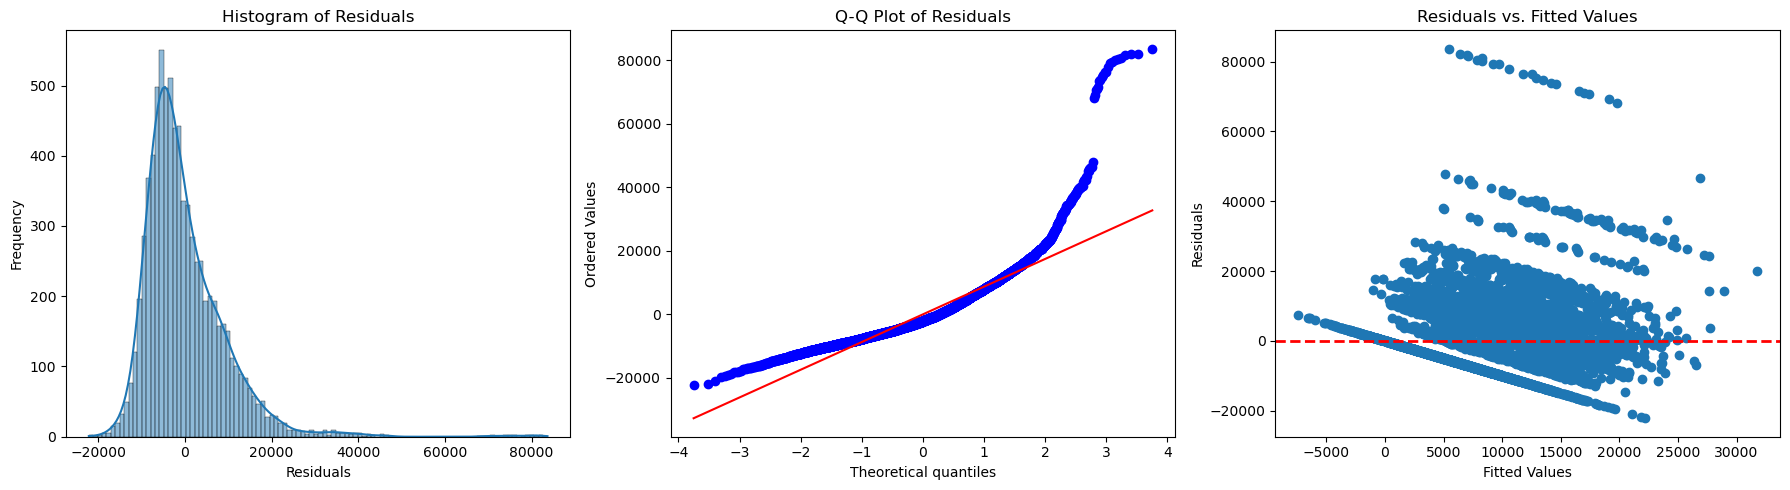

Breusch-Pagan Test Results:
{'LM Statistic': 273.1788196782718, 'LM-Test p-value': 3.845312389470348e-52, 'F-Statistic': 25.683885656759657, 'F-Test p-value': 4.224267665617925e-53}
The data has heteroskedasticity (p-value < 0.05). Applying Weighted Least Squares (WLS).
WLS Model Summary:
                               WLS Regression Results                              
Dep. Variable:     cumulative_time_seconds   R-squared:                       0.999
Model:                                 WLS   Adj. R-squared:                  0.999
Method:                      Least Squares   F-statistic:                 6.676e+05
Date:                     Thu, 01 Aug 2024   Prob (F-statistic):               0.00
Time:                             19:32:52   Log-Likelihood:                -77721.
No. Observations:                     7909   AIC:                         1.555e+05
Df Residuals:                         7897   BIC:                         1.555e+05
Df Model:                             

In [5]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming df_cleaned is your DataFrame
Xinitial = df_cleaned[['circuitId','driverId', 'grid', 'stop', 'rank', 'Race_Circuit', 'Street_Circuit', 'laps', 'year', 'constructorId','points']]
yinitial = df_cleaned['cumulative_time_seconds']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(Xinitial, yinitial, train_size=0.75, random_state=0)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the OLS model
model = sm.OLS(y_train, X_train)
results = model.fit()
print("OLS Model Summary:")
print(results.summary())

# To Handle multicolinearity
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
print(vif_data)

# Predicting on the training data
predicted_y = results.predict(X_train)
residuals = y_train - predicted_y

# Plotting the residuals
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
# Histogram of residuals
sns.histplot(residuals, kde=True, ax=ax[0])
ax[0].set_title('Histogram of Residuals')
ax[0].set_xlabel('Residuals')
ax[0].set_ylabel('Frequency')
# Q-Q plot of residuals
stats.probplot(residuals, dist="norm", plot=ax[1])
ax[1].set_title('Q-Q Plot of Residuals')
# Residuals vs. fitted values
ax[2].scatter(results.fittedvalues, residuals)
ax[2].axhline(0, color='red', linestyle='dashed', linewidth=2)
ax[2].set_title('Residuals vs. Fitted Values')
ax[2].set_xlabel('Fitted Values')
ax[2].set_ylabel('Residuals')
plt.tight_layout()
plt.show()

# Perform the Breusch-Pagan Test
bp_test = het_breuschpagan(results.resid, results.model.exog)
measures = ('LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value')
bp_results = dict(zip(measures, bp_test))
print("Breusch-Pagan Test Results:")
print(bp_results)
if bp_results['LM-Test p-value'] < 0.05 or bp_results['F-Test p-value'] < 0.05:
    print('The data has heteroskedasticity (p-value < 0.05). Applying Weighted Least Squares (WLS).')
    # Treat heteroskedasticity with WLS
    weights = 1 / (results.resid ** 2)
    wls_model = sm.WLS(y_train, X_train, weights=weights)
    wls_results = wls_model.fit()
    print("WLS Model Summary:")
    print(wls_results.summary())
else:
    print('The data does not have significant heteroskedasticity (p-value >= 0.05). No need to apply WLS.')

# Fit the OLS model with robust standard errors (regardless of heteroskedasticity result for comparison)
results_robust = results.get_robustcov_results(cov_type='HC3')
print("OLS Model with Robust Standard Errors Summary:")
print(results_robust.summary())

In [9]:
# Hypothesis Testing for the different circuit: Road, Race and Street

hypothesis = '(Race_Circuit=0, Street_Circuit=0)'
#Pass the hypothesis to the Wald_Test
print(results_robust.wald_test(hypothesis))

#We do not embrace the null and there is a difference between the different types of track and the time it takes to complete the race

<F test: F=array([[62.26236896]]), p=1.4817501629469654e-27, df_denom=7.9e+03, df_num=2>


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1906: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


Skewness of transformed cumulative_time_seconds: -0.19598903775263365
VIF Data:
               feature            VIF
0                const  270290.818699
1                 grid      18.445503
2                 stop       1.014493
3                 rank       1.593518
4         Race_Circuit      18.940374
5       Street_Circuit      18.810190
6                 laps       1.101929
7                 year       1.029900
8    Race_Circuit_grid      25.621225
9  Street_Circuit_grid      20.115156
OLS Model Summary with Transformed Dependent Variable:
                               OLS Regression Results                              
Dep. Variable:     cumulative_time_seconds   R-squared:                       0.320
Model:                                 OLS   Adj. R-squared:                  0.320
Method:                      Least Squares   F-statistic:                     413.8
Date:                     Thu, 01 Aug 2024   Prob (F-statistic):               0.00
Time:                      

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


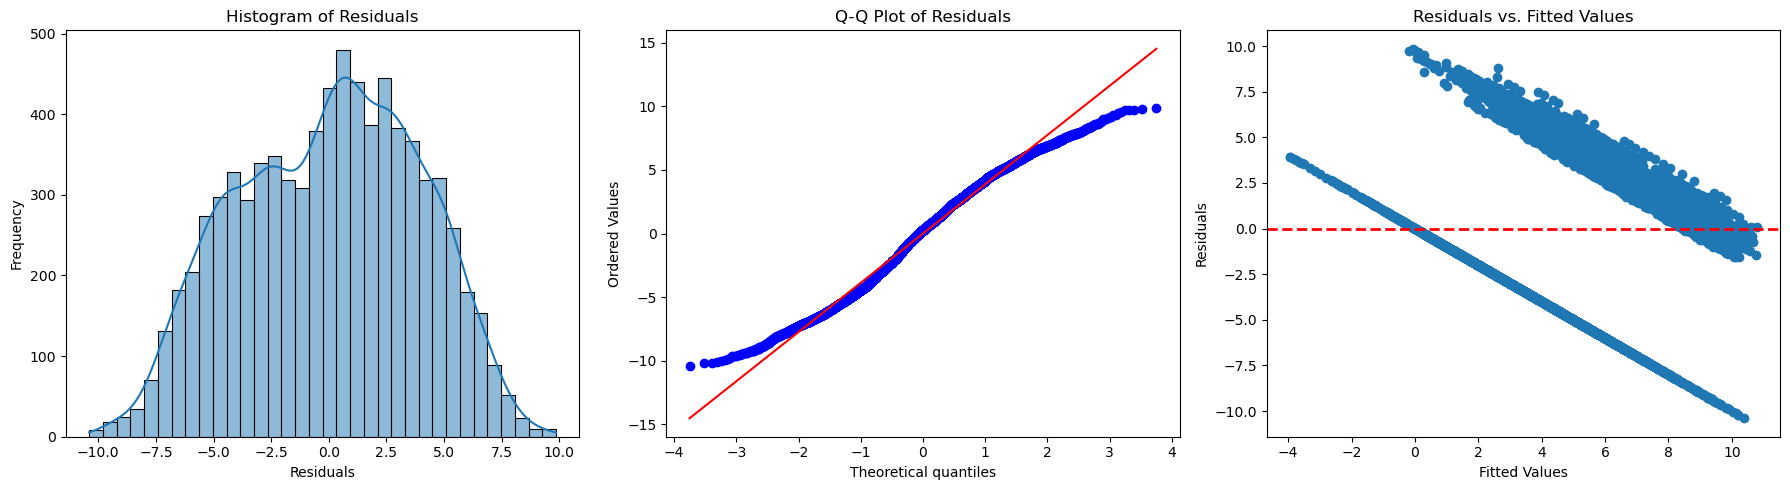

Breusch-Pagan Test Results:
{'LM Statistic': 329.9577331592434, 'LM-Test p-value': 1.1355297659380292e-65, 'F-Statistic': 38.209696371501636, 'F-Test p-value': 4.062596101603407e-67}
The data has heteroskedasticity (p-value < 0.05). Applying Weighted Least Squares (WLS).
WLS Model Summary:
                               WLS Regression Results                              
Dep. Variable:     cumulative_time_seconds   R-squared:                       1.000
Model:                                 WLS   Adj. R-squared:                  1.000
Method:                      Least Squares   F-statistic:                 4.075e+06
Date:                     Thu, 01 Aug 2024   Prob (F-statistic):               0.00
Time:                             19:37:07   Log-Likelihood:                -17649.
No. Observations:                     7909   AIC:                         3.532e+04
Df Residuals:                         7899   BIC:                         3.539e+04
Df Model:                            

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1906: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


In [10]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Assuming df_cleaned is your DataFrame

# Creating Dummy variables for splitting the two different types of circuits (street and race)
df_cleaned['Race_Circuit_grid'] = df_cleaned['Race_Circuit'] * df_cleaned['grid']
df_cleaned['Street_Circuit_grid'] = df_cleaned['Street_Circuit'] * df_cleaned['grid']



# Define the independent variables (X) and the dependent variable (y)
Xinitial = df_cleaned[['grid','stop', 'rank', 'Race_Circuit', 'Street_Circuit', 'laps', 'year', 'Race_Circuit_grid', 'Street_Circuit_grid']]
yinitial = df_cleaned['cumulative_time_seconds']

# Apply Natural Log Transformation to the dependent variable
yinitial_transformed = np.log(df_cleaned['cumulative_time_seconds'] + 1)
print(f"Skewness of transformed cumulative_time_seconds: {yinitial_transformed.skew()}")

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(Xinitial, yinitial_transformed, train_size=0.75, random_state=0)

# Add a constant to the model (intercept)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)


# Calculate VIF for each predictor
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
print("VIF Data:")
print(vif_data)

# Fit the OLS model
model = sm.OLS(y_train, X_train)
results = model.fit()
print("OLS Model Summary with Transformed Dependent Variable:")
print(results.summary())

# Predicting on the training data
predicted_y = results.predict(X_train)
residuals = y_train - predicted_y

# Plotting the residuals
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
# Histogram of residuals
sns.histplot(residuals, kde=True, ax=ax[0])
ax[0].set_title('Histogram of Residuals')
ax[0].set_xlabel('Residuals')
ax[0].set_ylabel('Frequency')   
# Q-Q plot of residuals
stats.probplot(residuals, dist="norm", plot=ax[1])
ax[1].set_title('Q-Q Plot of Residuals')
# Residuals vs. fitted values
ax[2].scatter(results.fittedvalues, residuals)
ax[2].axhline(0, color='red', linestyle='dashed', linewidth=2)  
ax[2].set_title('Residuals vs. Fitted Values')
ax[2].set_xlabel('Fitted Values')
ax[2].set_ylabel('Residuals')
plt.tight_layout()
plt.show()

# Perform the Breusch-Pagan Test
from statsmodels.stats.diagnostic import het_breuschpagan

bp_test = het_breuschpagan(results.resid, results.model.exog)
measures = ('LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value')
bp_results = dict(zip(measures, bp_test))
print("Breusch-Pagan Test Results:")
print(bp_results)

# Apply Weighted Least Squares (WLS) if heteroskedasticity is detected
if bp_results['LM-Test p-value'] < 0.05 or bp_results['F-Test p-value'] < 0.05:
    print('The data has heteroskedasticity (p-value < 0.05). Applying Weighted Least Squares (WLS).')
    weights = 1 / (results.resid ** 2)
    wls_model = sm.WLS(y_train, X_train, weights=weights)
    wls_results = wls_model.fit()
    print("WLS Model Summary:")
    print(wls_results.summary())

    # Predicting on the test data using the WLS model
    y_pred_test_wls = wls_results.predict(X_test)

    # Calculate performance metrics such as RMSE, R-squared, etc. for the WLS model
    rmse_test_wls = np.sqrt(mean_squared_error(y_test, y_pred_test_wls))
    r2_test_wls = r2_score(y_test, y_pred_test_wls)

    print(f"Test RMSE (WLS): {rmse_test_wls}")
    print(f"Test R-squared (WLS): {r2_test_wls}")
else:
    print('The data does not have significant heteroskedasticity (p-value >= 0.05). No need to apply WLS.')

hypothesis = '(Race_Circuit_grid=0)'
print(results.wald_test(hypothesis))